# Imports

In [12]:
import argparse
import cv2
import numpy as np
import imutils
import time
import os

# Setup

In [6]:
start = time.time()
SET_WIDTH = int(600)

normalize_image = 1 / 255.0
resize_image_shape = (1024, 512)

sample_img = cv2.imread('/content/drive/MyDrive/SemanticSegmentationData/images/example_02.jpg')
sample_img = imutils.resize(sample_img, width=SET_WIDTH)

blob_img = cv2.dnn.blobFromImage(sample_img, normalize_image,
resize_image_shape, 0,swapRB=True, crop=False)

# Model

In [7]:
# Load serialized ENET model
cv_enet_model = cv2.dnn.readNet('/content/drive/MyDrive/SemanticSegmentationData/enet-cityscapes/enet-model.net')

In [8]:
# Forward pass using segmentation model
cv_enet_model.setInput(blob_img)
cv_enet_model_output = cv_enet_model.forward()

In [9]:
# Load class name labels
label_values = open('/content/drive/MyDrive/SemanticSegmentationData/enet-cityscapes/enet-classes.txt').read().strip().split("\n")

In [10]:
# inferring shape of total number of classes, with spatial dimensions of mask image
IMG_OUTPUT_SHAPE_START =1
IMG_OUTPUT_SHAPE_END =4
(classes_num, h, w) = cv_enet_model_output.shape[IMG_OUTPUT_SHAPE_START:IMG_OUTPUT_SHAPE_END]

In [11]:
# take argmax to find class label with highest probability for (x, y) coordinate
class_map = np.argmax(cv_enet_model_output[0], axis=0)

In [13]:
if os.path.isfile('/content/drive/MyDrive/SemanticSegmentationData/enet-cityscapes/enet-colors.txt'):
    CV_ENET_SHAPE_IMG_COLORS = open('/content/drive/MyDrive/SemanticSegmentationData/enet-cityscapes/enet-colors.txt').read().strip().split("\n")
    CV_ENET_SHAPE_IMG_COLORS = [np.array(c.split(",")).astype("int") for c in CV_ENET_SHAPE_IMG_COLORS]
    CV_ENET_SHAPE_IMG_COLORS = np.array(CV_ENET_SHAPE_IMG_COLORS, dtype="uint8")
else:
    np.random.seed(42)
    CV_ENET_SHAPE_IMG_COLORS = np.random.randint(0, 255, size=(len(label_values) - 1, 3),
                               dtype="uint8")
    CV_ENET_SHAPE_IMG_COLORS = np.vstack([[0, 0, 0], CV_ENET_SHAPE_IMG_COLORS]).astype("uint8")

In [14]:
# Map each class ID with given class ID
mask_class_map = CV_ENET_SHAPE_IMG_COLORS[class_map]

In [15]:
# resize mask and class map so dimensions match original size of input image
mask_class_map = cv2.resize(mask_class_map, (sample_img.shape[1], sample_img.shape[0]),
                  interpolation=cv2.INTER_NEAREST)

class_map = cv2.resize(mask_class_map, (sample_img.shape[1], sample_img.shape[0]),
                      interpolation=cv2.INTER_NEAREST)

In [19]:
cv_enet_model_output = ((0.4 * sample_img) + (0.6 * mask_class_map)).astype("uint8")
my_legend = np.zeros(((len(label_values) * 25) + 25, 300, 3), dtype="uint8")
#loop over class names and colors, drawing class name and color on legend
for (i, (class_name, img_color)) in enumerate(zip(label_values, CV_ENET_SHAPE_IMG_COLORS)):
    # draw the class name + color on the legend
    color_info = [int(color) for color in img_color]
    cv2.putText(my_legend, class_name, (5, (i * 25) + 17),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    cv2.rectangle(my_legend, (100, (i * 25)), (300, (i * 25) + 25),
                  tuple(color_info), -1)

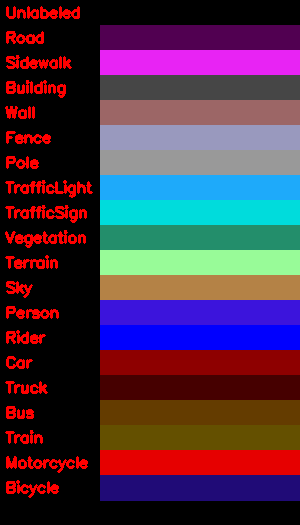

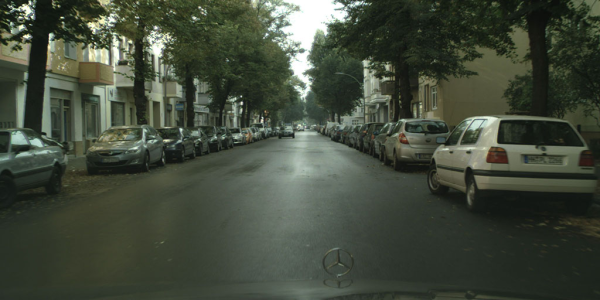

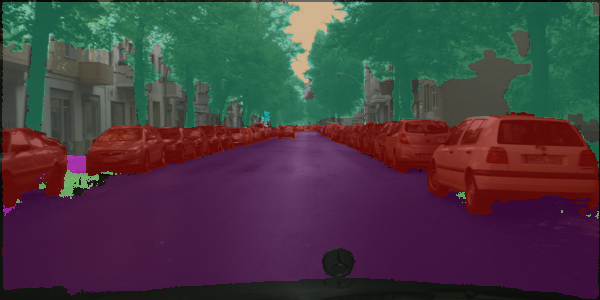

[INFO] inference took 575.4319 seconds


In [23]:
from google.colab.patches import cv2_imshow

cv2_imshow(my_legend)
cv2_imshow(sample_img)
cv2_imshow(cv_enet_model_output)

end = time.time()
print("[INFO] inference took {:.4f} seconds".format(end - start))